# 첫번째 이미지

In [1]:
# fail 이미지들 통합

import os
import shutil

# Source 디렉토리와 Target 디렉토리 설정
source_directories = ['C:/Users/kimfa/deep learning/fail(1)', 'C:/Users/kimfa/deep learning/fail(2)']
target_directory = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/fail'

# Target 디렉토리가 없으면 생성
if not os.path.exists(target_directory):
    os.makedirs(target_directory)

# Source 디렉토리마다 파일 이동
for idx, source_directory in enumerate(source_directories, start=1):
    for filename in os.listdir(source_directory):
        if f"({idx})" in filename:  # 해당 인덱스를 가진 파일만 선택
            source_path = os.path.join(source_directory, filename)
            target_path = os.path.join(target_directory, filename)
            shutil.copy(source_path, target_path)  # 파일 복사

In [7]:
# pass, fail 이미지 개수 확인

import cv2
import numpy as np
import os
import random

# 데이터 디렉토리
pass_directory = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/pass'
fail_directory = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/fail'

pass_images = [os.path.join(pass_directory, f) for f in os.listdir(pass_directory) if '(1).jpeg' in f]
fail_images = [os.path.join(fail_directory, f) for f in os.listdir(fail_directory) if '(1).jpeg' in f]
        
# pass와 fail이미지 개수 확인
pass_count = len(pass_images)
fail_count = len(fail_images)

print(f"Pass 이미지 개수: {pass_count}")
print(f"Fail 이미지 개수: {fail_count}")

Pass 이미지 개수: 4622
Fail 이미지 개수: 430


In [8]:
# train, test 데이터 분할

import os
import random

# 이미지 경로를 가져오는 함수 정의
def get_image_paths(directory, file_suffix):
    return [os.path.join(directory, f) for f in os.listdir(directory) if file_suffix in f]

# 이미지 경로 수집
pass_images = get_image_paths(pass_directory, '(1).jpeg')
fail_images = get_image_paths(fail_directory, '(1).jpeg')

# 이미지를 무작위로 섞기
random.shuffle(pass_images)
random.shuffle(fail_images)

# train과 test 세트로 분할 (8:2 비율)
split_index_pass = int(len(pass_images) * 0.8)
split_index_fail = int(len(fail_images) * 0.8)

train_pass_images = pass_images[:split_index_pass]
test_pass_images = pass_images[split_index_pass:]

train_fail_images = fail_images[:split_index_fail]
test_fail_images = fail_images[split_index_fail:]

# train 세트 내의 fail 이미지만 추출
# augment_fail_images = train_fail_images

# 각 세트의 이미지 수 확인
print(f"Train Pass Images: {len(train_pass_images)}")
print(f"Test Pass Images: {len(test_pass_images)}")
print(f"Train Fail Images: {len(train_fail_images)}")
print(f"Test Fail Images: {len(test_fail_images)}")

Train Pass Images: 3697
Test Pass Images: 925
Train Fail Images: 344
Test Fail Images: 86


In [9]:
# train, test 이미지 분할

import shutil
import os

# Train 폴더 및 Pass, Fail 서브 폴더 경로
train_folder = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train'
train_pass_folder = os.path.join(train_folder, 'Pass')
train_fail_folder = os.path.join(train_folder, 'Fail')

# Test 폴더 및 Pass, Fail 서브 폴더 경로
test_folder = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Test'
test_pass_folder = os.path.join(test_folder, 'Pass')
test_fail_folder = os.path.join(test_folder, 'Fail')

# 필요한 폴더들 생성 (이미 존재한다면 생성하지 않음)
os.makedirs(train_pass_folder, exist_ok=True)
os.makedirs(train_fail_folder, exist_ok=True)
os.makedirs(test_pass_folder, exist_ok=True)
os.makedirs(test_fail_folder, exist_ok=True)

# Train Pass 이미지 복사
for image_path in train_pass_images:
    shutil.copy(image_path, train_pass_folder)

# Train Fail 이미지 복사
for image_path in train_fail_images:
    shutil.copy(image_path, train_fail_folder)

# test Pass 이미지 복사
for image_path in test_pass_images:
    shutil.copy(image_path, test_pass_folder)

# test Fail 이미지 복사
for image_path in test_fail_images:
    shutil.copy(image_path, test_fail_folder)

In [10]:
# 이미지 증강 함수 정의, train 이미지의 fail 이미지만 증강  

import os
import random
from PIL import Image, ImageEnhance, ImageFilter
import numpy

def find_coeffs(pa, pb):
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = numpy.matrix(matrix, dtype=float)  # Use `float` instead of `numpy.float`
    B = numpy.array(pb).reshape(8)

    res = numpy.linalg.solve(A, B)
    return res.tolist()

def augment_image(image, file_path, original_filename, augment_cnt):
    # Randomly choose a type of augmentation
    random_augment = random.randint(1, 5)
    augmented_image_path = ""

    # 증강 유형에 따라 변형된 이미지를 저장하기 위한 변수
    transformed_image = image

    if random_augment == 1:
        augmentation_type = "skew2"
        width, height = image.size
        
        # 하단 꼭짓점은 그대로 유지하고 상단 꼭짓점은 왼쪽으로 0.15, 오른쪽으로 0.15 만큼 이동
        coeffs = find_coeffs(
            [(0, 0), (width, 0), (width, height), (0, height)],
            [(-width * 0.15, 0), (width + width * 0.15, 0), (width, height), (0, height)]
        )
        
        # 이미지 변형 (상단 부분만 좌우로 늘리기)
        transformed_image = image.transform(
            (width, height),  # 출력 이미지 크기
            Image.PERSPECTIVE,  # 변형 종류
            coeffs,  # 변형 계수
            resample=Image.BICUBIC  # 샘플링 방법
        )
        
    elif random_augment == 2:
        augmentation_type = "skew1"
        width, height = image.size
        
        # 상단 꼭짓점은 그대로 유지하고 하단 꼭짓점은 왼쪽으로 0.15, 오른쪽으로 0.15 만큼 이동
        coeffs = find_coeffs(
            [(0, 0), (width, 0), (width, height), (0, height)],
            [(0, 0), (width, 0), (width + width * 0.15, height), (-width * 0.15, height)]
        )
        
        # 이미지 변형 (하단 부분만 좌우로 늘리기)
        transformed_image = image.transform(
            (width, height),  # 출력 이미지 크기
            Image.PERSPECTIVE,  # 변형 종류
            coeffs,  # 변형 계수
            resample=Image.BICUBIC  # 샘플링 방법
        )
        
    elif random_augment == 3:
        augmentation_type = "brightened"
        # 밝기 조절 적용
        enhancer = ImageEnhance.Brightness(image)
        transformed_image = enhancer.enhance(1.5)
            
    elif random_augment == 4:
        augmentation_type = "blurred"
        # 블러 처리 적용
        blur_strength = 5  # 블러 처리 강도 설정
        transformed_image = image.filter(ImageFilter.BLUR)
        for _ in range(blur_strength):
            transformed_image = transformed_image.filter(ImageFilter.BLUR)
        
    elif random_augment == 5:
        augmentation_type = "nochange"
        # 이미지 변경 없음

    # 새 파일명 생성
    new_filename = f'{augmentation_type}_{original_filename}_{augment_cnt}.jpeg'
    augmented_image_path = os.path.join(file_path, new_filename)

    # 변형된 이미지 저장
    transformed_image.save(augmented_image_path)

    return augmented_image_path

# 증식된 이미지 저장할 폴더 경로
augmented_image_folder = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail'

# 증식된 이미지 저장할 폴더가 없다면 폴더 생성
if not os.path.exists(augmented_image_folder):
    os.makedirs(augmented_image_folder)
    
# 원본 이미지 폴더에서 파일 목록 가져오기
train_fail_directory = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail'
image_files = os.listdir(train_fail_directory)

# 각 이미지에 대해 증강 수행 및 저장
for idx, image_file in enumerate(image_files):
    image_path = os.path.join(train_fail_directory, image_file)
    filename_without_ext = os.path.splitext(image_file)[0]  # 파일 확장자 제거
    with Image.open(image_path) as img:
        for i in range(10):
            augmented_image_path = augment_image(img.copy(), augmented_image_folder, filename_without_ext, idx * 10 + i)
            print("Augmented image saved:", augmented_image_path.replace('\\', '/'))

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JL04105(1)_0.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04105(1)_1.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JL04105(1)_2.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JL04105(1)_3.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JL04105(1)_4.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04105(1)_5.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JL04105(1)_6.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JL04105(1)_7.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04121(1)_73.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JL04121(1)_74.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JL04121(1)_75.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JL04121(1)_76.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04121(1)_77.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JL04121(1)_78.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JL04121(1)_79.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04128(1)_80.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JL04170(1)_148.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JL04170(1)_149.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04179(1)_150.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JL04179(1)_151.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JL04179(1)_152.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04179(1)_153.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JL04179(1)_154.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JL04179(1)_155.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brig

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JL04205(1)_222.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JL04205(1)_223.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JL04205(1)_224.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JL04205(1)_225.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JL04205(1)_226.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04205(1)_227.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JL04205(1)_228.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JL04205(1)_229.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JL

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JL04231(1)_294.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04231(1)_295.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JL04231(1)_296.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04231(1)_297.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04231(1)_298.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04231(1)_299.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04238(1)_300.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JL04238(1)_301.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blur

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04253(1)_368.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04253(1)_369.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JL04255(1)_370.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JL04255(1)_371.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04255(1)_372.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JL04255(1)_373.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JL04255(1)_374.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JL04255(1)_375.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/ske

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JL04297(1)_441.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JL04297(1)_442.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JL04297(1)_443.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JL04297(1)_444.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JL04297(1)_445.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JL04297(1)_446.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JL04297(1)_447.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JL04297(1)_448.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JL

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04319(1)_514.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JL04319(1)_515.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JL04319(1)_516.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JL04319(1)_517.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JL04319(1)_518.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JL04319(1)_519.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04320(1)_520.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04320(1)_521.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nocha

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04336(1)_586.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JL04336(1)_587.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JL04336(1)_588.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JL04336(1)_589.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JL04339(1)_590.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JL04339(1)_591.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JL04339(1)_592.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JL04339(1)_593.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JP02439(1)_663.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JP02439(1)_664.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JP02439(1)_665.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JP02439(1)_666.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JP02439(1)_667.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JP02439(1)_668.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JP02439(1)_669.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JP02440(1)_670.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/bri

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JP02463(1)_735.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JP02463(1)_736.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JP02463(1)_737.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JP02463(1)_738.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JP02463(1)_739.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JP02465(1)_740.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JP02465(1)_741.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JP02465(1)_742.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JP02485(1)_809.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JP02487(1)_810.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JP02487(1)_811.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JP02487(1)_812.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JP02487(1)_813.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JP02487(1)_814.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JP02487(1)_815.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JP02487(1)_816.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JP02502(1)_881.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JP02502(1)_882.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JP02502(1)_883.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JP02502(1)_884.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JP02502(1)_885.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JP02502(1)_886.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JP02502(1)_887.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JP02502(1)_888.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/b

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JP02516(1)_954.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JP02516(1)_955.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JP02516(1)_956.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JP02516(1)_957.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JP02516(1)_958.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JP02516(1)_959.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JP02517(1)_960.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JP02517(1)_961.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JQ14298(1)_1026.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JQ14298(1)_1027.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JQ14298(1)_1028.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JQ14298(1)_1029.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JQ14306(1)_1030.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JQ14306(1)_1031.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JQ14306(1)_1032.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JQ14306(1)_1033.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JQ14343(1)_1098.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JQ14343(1)_1099.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JQ14344(1)_1100.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JQ14344(1)_1101.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JQ14344(1)_1102.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JQ14344(1)_1103.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JQ14344(1)_1104.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JQ14344(1)_1105.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JQ14374(1)_1170.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JQ14374(1)_1171.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JQ14374(1)_1172.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JQ14374(1)_1173.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JQ14374(1)_1174.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JQ14374(1)_1175.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JQ14374(1)_1176.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JQ14374(1)_1177.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JU05626(1)_1246.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JU05626(1)_1247.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JU05626(1)_1248.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JU05626(1)_1249.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JU05633(1)_1250.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JU05633(1)_1251.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JU05633(1)_1252.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JU05633(1)_1253.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fa

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JU05648(1)_1320.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JU05648(1)_1321.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JU05648(1)_1322.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JU05648(1)_1323.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JU05648(1)_1324.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JU05648(1)_1325.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JU05648(1)_1326.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JU05648(1)_1327.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/F

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JU05664(1)_1394.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JU05664(1)_1395.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JU05664(1)_1396.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JU05664(1)_1397.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JU05664(1)_1398.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JU05664(1)_1399.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JU05665(1)_1400.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JU05665(1)_1401.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/b

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JU05713(1)_1466.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JU05713(1)_1467.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JU05713(1)_1468.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JU05713(1)_1469.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JU05714(1)_1470.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JU05714(1)_1471.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JU05714(1)_1472.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JU05714(1)_1473.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fai

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JU05750(1)_1542.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JU05750(1)_1543.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JU05750(1)_1544.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JU05750(1)_1545.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JU05750(1)_1546.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JU05750(1)_1547.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JU05750(1)_1548.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JU05750(1)_1549.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JU05778(1)_1615.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JU05778(1)_1616.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JU05778(1)_1617.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JU05778(1)_1618.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JU05778(1)_1619.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JU05786(1)_1620.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JU05786(1)_1621.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JU05786(1)_1622.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fa

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JY02413(1)_1688.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JY02413(1)_1689.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JY02416(1)_1690.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JY02416(1)_1691.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JY02416(1)_1692.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4JY02416(1)_1693.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JY02416(1)_1694.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JY02416(1)_1695.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/T

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JY02435(1)_1761.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JY02435(1)_1762.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JY02435(1)_1763.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JY02435(1)_1764.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JY02435(1)_1765.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JY02435(1)_1766.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JY02435(1)_1767.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4JY02435(1)_1768.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/s

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4JY02469(1)_1837.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4JY02469(1)_1838.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4JY02469(1)_1839.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KA02017(1)_1840.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KA02017(1)_1841.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KA02017(1)_1842.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KA02017(1)_1843.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KA02017(1)_1844.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Tr

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KB02460(1)_1911.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KB02460(1)_1912.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KB02460(1)_1913.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KB02460(1)_1914.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KB02460(1)_1915.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KB02460(1)_1916.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KB02460(1)_1917.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KB02460(1)_1918.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nocha

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KB02517(1)_1983.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KB02517(1)_1984.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KB02517(1)_1985.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KB02517(1)_1986.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KB02517(1)_1987.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KB02517(1)_1988.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KB02517(1)_1989.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KB02518(1)_1990.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/F

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05016(1)_2055.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05016(1)_2056.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05016(1)_2057.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05016(1)_2058.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05016(1)_2059.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05019(1)_2060.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05019(1)_2061.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05019(1)_2062.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/no

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05039(1)_2127.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05039(1)_2128.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05039(1)_2129.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05041(1)_2130.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05041(1)_2131.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05041(1)_2132.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05041(1)_2133.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05041(1)_2134.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Trai

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05059(1)_2206.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05059(1)_2207.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05059(1)_2208.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05059(1)_2209.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05067(1)_2210.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05067(1)_2211.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05067(1)_2212.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05067(1)_2213.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/ske

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05081(1)_2279.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05084(1)_2280.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05084(1)_2281.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05084(1)_2282.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05084(1)_2283.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05084(1)_2284.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05084(1)_2285.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05084(1)_2286.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fa

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05113(1)_2353.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05113(1)_2354.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05113(1)_2355.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05113(1)_2356.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05113(1)_2357.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05113(1)_2358.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05113(1)_2359.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05117(1)_2360.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05135(1)_2427.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05135(1)_2428.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05135(1)_2429.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05138(1)_2430.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05138(1)_2431.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05138(1)_2432.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05138(1)_2433.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05138(1)_2434.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Trai

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05155(1)_2499.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05156(1)_2500.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05156(1)_2501.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05156(1)_2502.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05156(1)_2503.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05156(1)_2504.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05156(1)_2505.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05156(1)_2506.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fa

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05177(1)_2572.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05177(1)_2573.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05177(1)_2574.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05177(1)_2575.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05177(1)_2576.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05177(1)_2577.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05177(1)_2578.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05177(1)_2579.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/59

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05197(1)_2643.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05197(1)_2644.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05197(1)_2645.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05197(1)_2646.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05197(1)_2647.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05197(1)_2648.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05197(1)_2649.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05199(1)_2650.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fai

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05217(1)_2717.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05217(1)_2718.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05217(1)_2719.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05219(1)_2720.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05219(1)_2721.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05219(1)_2722.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05219(1)_2723.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05219(1)_2724.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/s

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05247(1)_2793.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05247(1)_2794.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05247(1)_2795.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05247(1)_2796.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05247(1)_2797.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05247(1)_2798.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05247(1)_2799.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05248(1)_2800.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fa

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05266(1)_2865.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05266(1)_2866.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05266(1)_2867.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05266(1)_2868.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05266(1)_2869.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05268(1)_2870.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05268(1)_2871.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05268(1)_2872.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/F

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05289(1)_2937.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05289(1)_2938.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05289(1)_2939.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05291(1)_2940.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05291(1)_2941.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05291(1)_2942.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05291(1)_2943.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05291(1)_2944.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Trai

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05320(1)_3011.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05320(1)_3012.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05320(1)_3013.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05320(1)_3014.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05320(1)_3015.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05320(1)_3016.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05320(1)_3017.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05320(1)_3018.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fai

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05337(1)_3083.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05337(1)_3084.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05337(1)_3085.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05337(1)_3086.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05337(1)_3087.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05337(1)_3088.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05337(1)_3089.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05343(1)_3090.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/b

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05368(1)_3157.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05368(1)_3158.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05368(1)_3159.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05370(1)_3160.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05370(1)_3161.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05370(1)_3162.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05370(1)_3163.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05370(1)_3164.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Trai

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05393(1)_3231.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05393(1)_3232.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05393(1)_3233.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05393(1)_3234.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05393(1)_3235.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/nochange_4KE05393(1)_3236.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05393(1)_3237.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05393(1)_3238.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/s

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05416(1)_3303.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05416(1)_3304.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05416(1)_3305.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05416(1)_3306.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05416(1)_3307.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05416(1)_3308.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05416(1)_3309.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05420(1)_3310.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brig

Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05441(1)_3379.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew2_4KE05443(1)_3380.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/brightened_4KE05443(1)_3381.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05443(1)_3382.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05443(1)_3383.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05443(1)_3384.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/skew1_4KE05443(1)_3385.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/blurred_4KE05443(1)_3386.jpeg
Augmented image saved: C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail/

In [13]:
# 클리핑 함수 정의, train에서 pass와 fail 이미지를 클리핑해서 저장

from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np

def shift_and_clip_image(image_path, save_path, shift_x=100, shift_y=-150, new_width=1100, new_height=500):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    height, width = image.shape[:2]
    
    # 이미지 이동
    M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    shifted_image = cv2.warpAffine(image, M, (width, height))
    
    # 이미지 클리핑
    start_x = max(width // 2 - new_width // 2, 0)
    start_y = max(height // 2 - new_height // 2, 0)
    end_x = min(start_x + new_width, width)
    end_y = min(start_y + new_height, height)
    clipped_image = shifted_image[start_y:end_y, start_x:end_x]

    # 클리핑된 이미지 저장
    cv2.imwrite(save_path, clipped_image)

# pass와 fail 이미지 경로 설정
train_pass_images_directory = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Pass'
train_fail_images_directory = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Fail'

# pass 이미지 경로에서 이미지 목록 가져오기
pass_images = [os.path.join(train_pass_images_directory, f) for f in os.listdir(train_pass_images_directory)]

# fail 이미지 경로에서 이미지 목록 가져오기
fail_images = [os.path.join(train_fail_images_directory, f) for f in os.listdir(train_fail_images_directory)]

# 클리핑된 이미지 저장할 서브 폴더 경로 설정
clip_pass_directory = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Clipped/Pass'
clip_fail_directory = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Clipped/Fail'

# 필요한 경우 서브 폴더 생성
if not os.path.exists(clip_pass_directory):
    os.makedirs(clip_pass_directory)
if not os.path.exists(clip_fail_directory):
    os.makedirs(clip_fail_directory)
    
# pass 이미지 클리핑해서 저장
for pass_image_path in pass_images:
    original_filename = os.path.basename(pass_image_path)
    save_name = os.path.join(clip_pass_directory, original_filename)
    shift_and_clip_image(pass_image_path, save_name)

# fail 이미지 클리핑해서 저장
for fail_image_path in fail_images:
    original_filename = os.path.basename(fail_image_path)
    save_name = os.path.join(clip_fail_directory, original_filename)
    shift_and_clip_image(fail_image_path, save_name)

In [14]:
# test에서  pass와 fail 이미지를 클리핑해서 저장

# pass와 fail 이미지 경로 설정
test_pass_images_directory = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Test/Pass'
test_fail_images_directory = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Test/Fail'

# pass 이미지 경로에서 이미지 목록 가져오기
pass_images = [os.path.join(test_pass_images_directory, f) for f in os.listdir(test_pass_images_directory)]

# fail 이미지 경로에서 이미지 목록 가져오기
fail_images = [os.path.join(test_fail_images_directory, f) for f in os.listdir(test_fail_images_directory)]

# 클리핑된 이미지 저장할 서브 폴더 경로 설정
clip_pass_directory = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Test/Clipped/Pass'
clip_fail_directory = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Test/Clipped/Fail'

# 필요한 경우 서브 폴더 생성
if not os.path.exists(clip_pass_directory):
    os.makedirs(clip_pass_directory)
if not os.path.exists(clip_fail_directory):
    os.makedirs(clip_fail_directory)
    
# pass 이미지 클리핑해서 저장
for pass_image_path in pass_images:
    original_filename = os.path.basename(pass_image_path)
    save_name = os.path.join(clip_pass_directory, original_filename)
    shift_and_clip_image(pass_image_path, save_name)

# fail 이미지 클리핑해서 저장
for fail_image_path in fail_images:
    original_filename = os.path.basename(fail_image_path)
    save_name = os.path.join(clip_fail_directory, original_filename)
    shift_and_clip_image(fail_image_path, save_name)

In [9]:
# 데이터셋을 위한 전처리 작업

import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

# 데이터 전처리
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 트레인 및 테스트 데이터셋 경로 설정
train_directory = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Clipped'
test_directory = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Test/Clipped'

# ImageFolder를 사용하여 트레인 및 테스트 데이터셋 불러오기
train_data = ImageFolder(root=train_directory, transform=data_transforms)
test_data = ImageFolder(root=test_directory, transform=data_transforms)

# 데이터 로더 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# MobileNetV3 모델 로드 및 수정
model = models.mobilenet_v3_large(pretrained=True)
num_classes = 2
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

# 손실 함수 및 Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train() 함수 정의
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    
    return epoch_loss, epoch_accuracy

# validate() 함수 정의
def validate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_accuracy = correct / total
    
    return epoch_loss, epoch_accuracy

C:\Users\kimfa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kimfa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


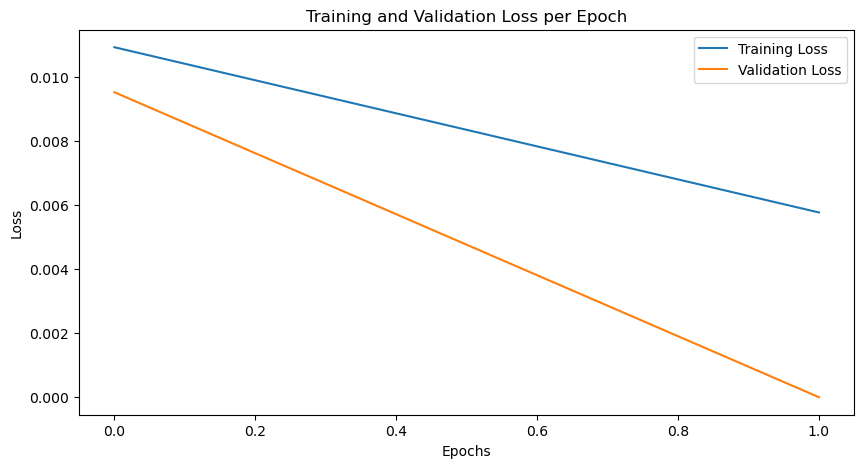

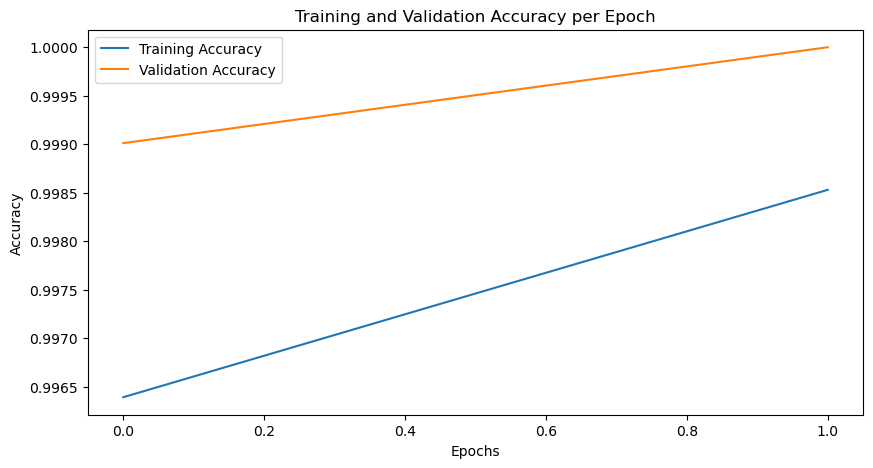

In [10]:
import matplotlib.pyplot as plt

# 모델 학습 및 검증
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_data)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # 테스트 과정
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_data)
    test_accuracy = correct / total
    val_losses.append(test_loss)
    val_accuracies.append(test_accuracy)

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [5]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

# 데이터셋을 위한 전처리 작업
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 트레인 및 테스트 데이터셋 경로 설정
train_directory = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Train/Clipped'
test_directory = 'C:/Users/kimfa/deep learning/Image_Data/5951C008AA/Test/Clipped'

# ImageFolder를 사용하여 트레인 및 테스트 데이터셋 불러오기
train_data = ImageFolder(root=train_directory, transform=data_transforms)
test_data = ImageFolder(root=test_directory, transform=data_transforms)

# 데이터 로더 생성
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# MobileNetV3 모델 로드 및 수정
model = models.mobilenet_v3_large(pretrained=True)
num_classes = 2
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

# 손실 함수 및 Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_data)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}")
    
    # 테스트 과정
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] Test Accuracy: {accuracy:.4f}")

Epoch [1/2] Train Loss: 0.0165
Epoch [1/2] Test Accuracy: 1.0000
Epoch [2/2] Train Loss: 0.0027
Epoch [2/2] Test Accuracy: 1.0000


In [ ]:
# 테스트 이미지 중 일부 선택하여 모델 예측 평가

import torch
from torch.utils.data.sampler import SubsetRandomSampler

# 모델을 evaluation 모드로 변경
model.eval()

# 테스트 이미지 중 일부를 선택
num_images = 10
sample_indices = torch.randperm(len(test_data))[:num_images]
sample_loader = DataLoader(test_data, batch_size=num_images, sampler=SubsetRandomSampler(sample_indices))

# 모델의 예측 수행
with torch.no_grad():
    for inputs, labels in sample_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions = predicted.tolist()

# 시각화
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2행 5열의 그리드 생성
for i, ax in enumerate(axes.flatten()):
    true_label = test_data[sample_indices[i]][1]  # 이미지 레이블 가져오기
    predicted_label = predictions[i]
    sample_image = test_data[sample_indices[i]][0]  # 이미지 가져오기 (레이블은 [0], 이미지는 [1])
    
    # 이미지와 레이블을 축에 표시
    ax.imshow(sample_image.permute(1, 2, 0))  # 이미지 차원을 변경하여 시각화 (channels_last)
    ax.set_title(f'True: {true_label}, Predicted: {predicted_label}')
    ax.axis('off')  # 축 정보 제거
plt.tight_layout()
plt.show()